## RBF vs Nystroem kernel approximation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import svm, pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
# from sklearn.decomposition import PCA
from sklearn import datasets

In [3]:
# load digits dataset

digits = datasets.load_digits(n_class=9)
# digits = datasets.fetch_mldata("MNIST original")

print(digits.data.shape)
# plt.matshow(digits.images[0])
# it contains 1617 images of digits. 
# Each image is represented by an 8x8 matrix.

(1617, 64)


In [4]:
n_samples = len(digits.data)
# normalize data: here pixels have values between 0 and 16

data = digits.data / 16.
# each image is a row vector with 64 entries.
# we take the mean of each column, which gives 64 means (one over each component of the image)
mean = data.mean(axis=0)
len(mean)

# averaging
data -= mean

In [5]:
# train-test half split 
train_data, train_labels = (data[:n_samples // 2], digits.target[:n_samples // 2])
test_data, test_labels = (data[n_samples // 2:], digits.target[n_samples // 2:])

In [6]:
# SVM classifiers
gamma = 0.5
kernel_svm = svm.SVC(kernel='rbf', gamma=gamma)
linear_svm = svm.SVC(kernel='linear')

In [7]:
# the two methods
random_fourier = RBFSampler(gamma=gamma, random_state=1)
nystroem = Nystroem(gamma=gamma, random_state=1)

# pipelines for kernel approxixmations
fourier_svm = pipeline.Pipeline([("feature_map", random_fourier),("svm", linear_svm)])
nystroem_svm = pipeline.Pipeline([("feature_map", nystroem),("svm", linear_svm)])

In [8]:
# fit and predict linear and kernel SVMs
start = time()
kernel_svm.fit(train_data, train_labels)
kernel_svm_score = kernel_svm.score(test_data,test_labels)
kernel_svm_time = time() - start

start = time()
linear_svm.fit(train_data, train_labels)
linear_svm_score = linear_svm.score(test_data, test_labels)
linear_svm_time = time() - start

In [9]:
print("      ","      time        ", "  accuracy")
print("kernel",kernel_svm_time, kernel_svm_score)
print("linear",linear_svm_time, linear_svm_score)

             time           accuracy
kernel 0.13774418830871582 0.9715698393077874
linear 0.0271604061126709 0.9493201483312732


In [10]:
# number of random samples
sample_sizes = 30 * np.arange(1,10)
sample_sizes

array([ 30,  60,  90, 120, 150, 180, 210, 240, 270])

In [11]:
nystroem_scores = []
nystroem_times = []

for D in sample_sizes:
    # set the number of samples
    nystroem_svm.set_params(feature_map__n_components=D)
    
    start = time()
    nystroem_svm.fit(train_data, train_labels)
    nystroem_times.append(time() - start)

    nystroem_score = nystroem_svm.score(test_data, test_labels)
    nystroem_scores.append(nystroem_score)
    
nystroem_scores

[0.7985166872682324,
 0.9011124845488258,
 0.9208899876390606,
 0.9208899876390606,
 0.9505562422744128,
 0.9530284301606922,
 0.9480840543881335,
 0.9592088998763906,
 0.9567367119901112]

In [12]:
fourier_scores = []
fourier_times = []

for D in sample_sizes:
    fourier_svm.set_params(feature_map__n_components=D)

    start = time()
    fourier_svm.fit(train_data, train_labels)
    fourier_times.append(time() - start)

    fourier_score = fourier_svm.score(test_data, test_labels)
    fourier_scores.append(fourier_score)

fourier_scores

[0.5661310259579728,
 0.6872682323856613,
 0.7787391841779975,
 0.7700865265760197,
 0.8405438813349815,
 0.8491965389369592,
 0.8739184177997528,
 0.8912237330037083,
 0.9023485784919654]

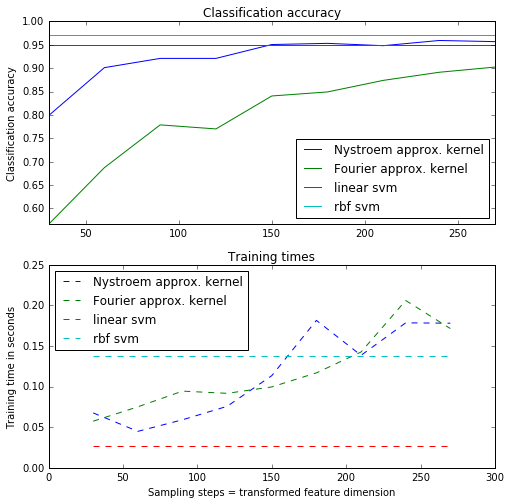

In [13]:
# plot the results
plt.figure(figsize=(8, 8))

accuracy = plt.subplot(211)
# second y axis for timings
timescale = plt.subplot(212)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
# accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
# accuracy.set_xticks(())
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show()

## MNIST original

Following this: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/


In [92]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
digits = X_train

print(X_train.shape)

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]

X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

print(X_train.shape)
# normalize from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# now to -1 - 1
train_mean = X_train.mean(axis=0)
test_mean = X_test.mean(axis=0)

X_train -= train_mean
X_test -= test_mean

(60000, 28, 28)
(60000, 784)


In [93]:
print(X_train.shape[0],X_test.shape[0])

# still taking a subset on my machine...
# PROVARE CON TUTTO IL DATASET SU CINECA (appena ho l'accesso)
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:1000]
y_test = y_test[:1000]

print(X_train.shape[0],X_test.shape[0])

60000 10000
5000 1000


In [81]:
# # fit and predict linear and kernel SVMs
# start = time()
# kernel_svm.fit(X_train, y_train)
# kernel_svm_score = kernel_svm.score(X_test,y_test)
# kernel_svm_time = time() - start

# start = time()
# linear_svm.fit(X_train, y_train)
# linear_svm_score = linear_svm.score(X_test,y_test)
# linear_svm_time = time() - start

In [94]:
# number of random samples
sample_sizes = 50 * np.arange(1,10)
sample_sizes

array([ 50, 100, 150, 200, 250, 300, 350, 400, 450])

In [95]:
# nystroem_scores = []
# nystroem_times = []

# for D in sample_sizes:
#     # set the number of samples
#     nystroem_svm.set_params(feature_map__n_components=D)

#     start = time()
#     nystroem_svm.fit(X_train, y_train)
#     nystroem_times.append(time() - start)

#     nystroem_score = nystroem_svm.score(X_test, y_test)
#     nystroem_scores.append(nystroem_score)
    
# nystroem_scores

[0.126, 0.126, 0.126, 0.126, 0.17, 0.125, 0.13, 0.121, 0.121]

In [85]:
# fourier_scores = []
# fourier_times = []

# for D in sample_sizes:
#     fourier_svm.set_params(feature_map__n_components=D)

#     start = time()
#     fourier_svm.fit(X_train, y_train)
#     fourier_times.append(time() - start)

#     fourier_score = fourier_svm.score(X_test, y_test)
#     fourier_scores.append(fourier_score)

# fourier_scores

[0.124, 0.122, 0.106, 0.124, 0.092, 0.14, 0.11, 0.086, 0.12]

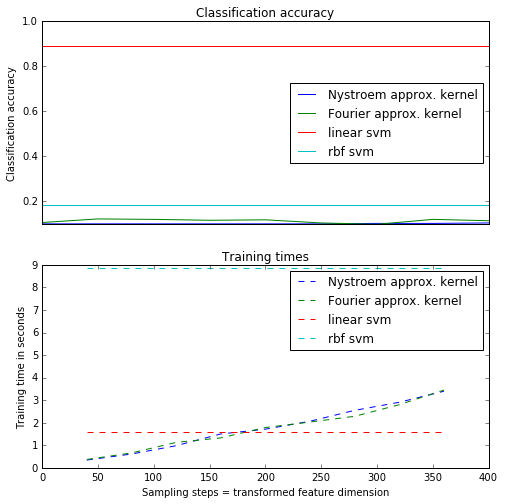

In [41]:
# plot the results
plt.figure(figsize=(8, 8))
accuracy = plt.subplot(211)
# second y axis for timings
timescale = plt.subplot(212)

accuracy.plot(sample_sizes, nystroem_scores, label="Nystroem approx. kernel")
timescale.plot(sample_sizes, nystroem_times, '--',
               label='Nystroem approx. kernel')

accuracy.plot(sample_sizes, fourier_scores, label="Fourier approx. kernel")
timescale.plot(sample_sizes, fourier_times, '--',
               label='Fourier approx. kernel')

# horizontal lines for exact rbf and linear kernels:
accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [linear_svm_score, linear_svm_score], label="linear svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [linear_svm_time, linear_svm_time], '--', label='linear svm')

accuracy.plot([sample_sizes[0], sample_sizes[-1]],
              [kernel_svm_score, kernel_svm_score], label="rbf svm")
timescale.plot([sample_sizes[0], sample_sizes[-1]],
               [kernel_svm_time, kernel_svm_time], '--', label='rbf svm')

# vertical line for dataset dimensionality = 64
# accuracy.plot([64, 64], [0.7, 1], label="n_features")

# legends and labels
accuracy.set_title("Classification accuracy")
timescale.set_title("Training times")
accuracy.set_xlim(sample_sizes[0], sample_sizes[-1])
accuracy.set_ylim(np.min(fourier_scores), 1)
timescale.set_xlabel("Sampling steps = transformed feature dimension")
accuracy.set_ylabel("Classification accuracy")
timescale.set_ylabel("Training time in seconds")
accuracy.legend(loc='best')
timescale.legend(loc='best')

plt.show()